In [ ]:
!pip install qiskit['visulization']
!pip install qiskit-aer

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import XGate, YGate, ZGate, CPhaseGate
from qiskit.circuit import CircuitInstruction, Gate
from numpy import random, math, binary_repr
from copy import deepcopy
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.providers.fake_provider import GenericBackendV2

seed = 10;
random.seed = seed;

backend = GenericBackendV2(num_qubits=5)
sim = AerSimulator(seed_simulator=seed);

def circuit_compile(cirq: QuantumCircuit):
  """

  Args:
    cirq: input circuit

  Returns: A copy of the input circuit with gates transformed into choosen basis gates

  """
  basis_gates = ['cx','id','rz','sx','x']
  return transpile(cirq, basis_gates=basis_gates, optimization_level=3,);

def choose_random_gate():
  """
  Randomly selects a pauli operation

  Returns: selected gate instruction.
  """
  choice_gate = random.choice(3);
  match choice_gate:
    case 0:
      gate = XGate()
    case 1:
      gate = YGate()
    case 2:
      gate = ZGate()
  return gate;

def gate_add(cirq: QuantumCircuit, is_single_qubit_noise: bool, is_two_qubit_noise: bool):
  """
  Assuming noise is added to all qubits.
  Update the same input circuit

  Args:
    cirq: input circuit
    is_single_qubit_noise: 0/1 (if single qubit noise is to be applied)
    is_two_qubit_noise: 0/1 (if two qubit noise is to be applied)
  """

  cirq_len = len(cirq.data);
  # iterate backwards and add noisy gates at the the right of the original gate operations.
  for i in range(cirq_len - 1, -1, -1):
    # Only for those instruction which are of gate type
    if isinstance(cirq.data[i].operation, Gate):
      if is_single_qubit_noise and cirq.data[i].operation.num_qubits == 1:
        gate = choose_random_gate();
        #insert random operation
        cirq.data.insert(i+1, CircuitInstruction(operation = gate, qubits = cirq.data[i].qubits, clbits=()))
      if is_two_qubit_noise and cirq.data[i].operation.num_qubits == 2:
        gate = choose_random_gate();
        #insert random operation
        cirq.data.insert(i+1, CircuitInstruction(operation = gate, qubits = tuple([cirq.data[i].qubits[0]]), clbits=()))
        cirq.data.insert(i+1, CircuitInstruction(operation = gate, qubits = tuple([cirq.data[i].qubits[1]]), clbits=()))

def NoiseAdder(a: float, b: float, circuit: QuantumCircuit):
  """
  Assuming noise is added to all qubits.

  Args:
    a: probability of single qubit gate noise
    b: probability of two qubit gate noise
    circuit: Input circuit

  Returns: A copy of input circuit with noise added

  """
  assert a >= 0 and a < 1, "noise probabiltiy for single qubit gates should be between [0,1]"
  assert b >= 0 and b < 1, "noise probabiltiy for two qubit gates should be between [0,1]"

  noisy_cirq = circuit.copy();
  # random sampling for choice of noise based on probability
  choose = lambda prob : random.choice([False,True], p = [1-prob, prob]);

  # generate noisy circuit
  gate_add(noisy_cirq, choose(a), choose(b));
  return noisy_cirq;


<ipython-input-165-9995c1d28f2b>:5: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  from numpy import random, math, binary_repr


In [ ]:
def Rn(n: float):
  """

  Args:
    n: phase power

  Returns: CPhase gate with required rotation.

  """
  return CPhaseGate(2**(1-n) * math.pi);

def QFT(n_qubits: int):
  """

  Args:
    n_qubits: circuit size

  Returns: returns a QFT circuit

  """
  cirq = QuantumCircuit(n_qubits);
  for i in range(n_qubits-1, -1, -1):
    for n in range(0, n_qubits-1 - i):
      cirq.append(Rn(n + 2) ,[i+1+n, i]);
    cirq.h(i);
  return cirq;

def dapperAdder(a: int, b: int):
  """

  Args:
    a: number to sum
    b:  number to sum

  Returns: dapper adder circuit

  """
  # Find nummber of qubit required
  N = math.ceil(math.log2(max(a,b) + 1));
  n_qubits = 2*N + 1;
  b_binary = binary_repr(b, width = N);
  a_binary = binary_repr(a, width = N);

  # Initialize circuit
  add_cirq = QuantumCircuit(n_qubits, N+1);
  add_cirq.initialize(Statevector.from_label(b_binary), range(0, N));
  add_cirq.initialize(Statevector.from_label('0' + a_binary),  range(N, n_qubits))

  # QFT
  add_cirq.compose(QFT(N+1), qubits = range(N, n_qubits), inplace = True);

  # Adder circuit
  for i in range(N, n_qubits):
    if i == n_qubits - 1 :
      for n in range(0, N):
        add_cirq.append(Rn(n+2), [n, i])
    else:
      for n in range(0, i - N + 1):
        add_cirq.append(Rn(n + 1), [n_qubits - 2 - i + n, i])

  #Inverse QFT
  add_cirq.compose(QFT(N+1).inverse(),  qubits = range(N, n_qubits), inplace = True);

  # Measure
  add_cirq.measure(range(N, n_qubits), range(0, N + 1));
  return add_cirq


def exp(add_noise, alpha = 0.5, beta = 0.5):
  """

  Experimentation function

  Args:
    add_noise: if noise is added or not
    alpha: single qubit gte noise
    beta: two qubit gate noise

  Returns: histogram

  """
  ## Adder circuit
  add = dapperAdder(3, 3);

  ## Conversion to basis gates
  comp_add = circuit_compile(add)

  ## Noise model
  if add_noise:
    res = sim.run(NoiseAdder(alpha, beta, comp_add)).result();
  else:
    res = sim.run(comp_add).result();

  print(res.get_counts())
  return plot_histogram(res.get_counts())


### No Noise Experiment

{'110': 1024}


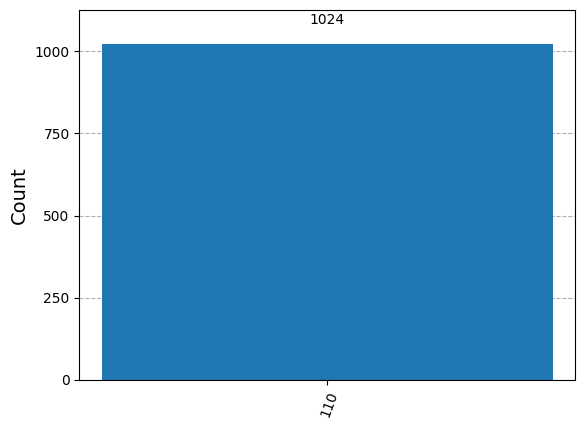

In [ ]:
exp(0)

### Noisy Experiment

{'100': 8, '000': 7, '101': 34, '001': 203, '110': 282, '011': 88, '111': 402}


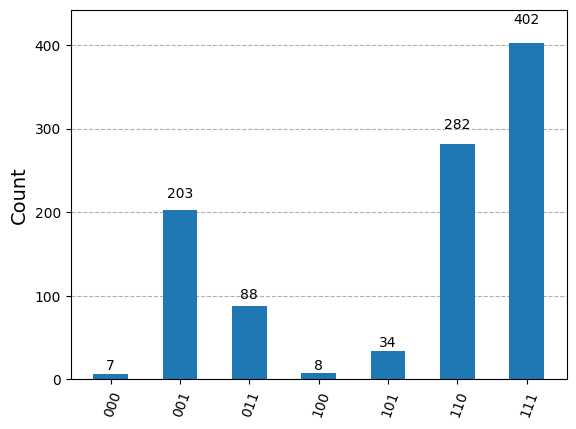

In [ ]:
exp(1)

### Extra Noisy Experiment

{'000': 252, '100': 255, '001': 517}


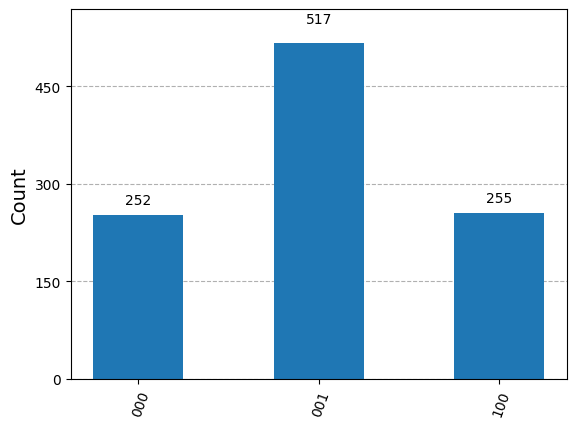

In [ ]:
exp(1, 0.9, 0.9)


## Answers


- How does the noise affect the results?
**  Noise leads to probabilistic results of multiple possible answers. Hence create error in results.

- Is there a way to decrease the effect of noise?
** By reducing noise problilities.
**  By error correction techniques like surface codes

- How does the number of gates used affect the results?
** With more gates the error increases as there will be more noise introduced
